In [1]:
import rasterio
from rasterio.windows import Window
import rasterio.features
from rasterio.mask import mask
from rasterio.plot import show

import geopandas as gpd
from geopandas.tools import sjoin
from affine import Affine
from pyproj import Proj, transform
from shapely.geometry import Point,shape,mapping

from scipy import ndimage
import numpy as np
import re
import os,glob
import time
from pathlib import Path

import matplotlib.pyplot as plt
# import geoplot

In [9]:
# medfile = 'e:/Data/VNL_multiyear/SVDNB_npp_20140101-20191231_global_vcmslcfg_v10_c20201020.max_median_rade9.cvg_ge_3'
# pctfile = 'e:/Data/VNL_multiyear/SVDNB_npp_20140101-20191231_global_vcmslcfg_v10_c20201110.pct.dat'
# rangefile = 'e:/Data/VNL_multiyear/VNL_max_median_data_range.dat'

# pctfile = 'e:/Data/VNL_multiyear/VNL__npp_20140101-20191231_global_vcmslcfg_v10_c202101061400.pct.dat'
# rangefile = 'e:/Data/VNL_multiyear/VNL_npp_20140401-20191231_global_vcmslcfg_v10_c202101061400.max_range_3x3_rade9.cvg_ge_3.dat'

pctfile = 'e:/Data/VNL_multiyear/VNL_npp_2012-2020_global_v2_c202102041100.pct.dat'
rangefile = 'e:/Data/VNL_multiyear/VNL_npp_2012-2020_global_v2_c202101211500.max_median_data_range_rade9.dat'

# data_path = Path('d:/Data/VNL_multiyear/')
data_path = 'e:/Data/VNL_multiyear/'

version = 7

In [10]:
# https://github.com/geopandas/geopandas/blob/master/examples/spatial_joins.ipynb

aurora_north = gpd.read_file('d:\Data\VNL_2019\VNL_2019_median_no_aurora_20200911.shp')
north_limit = aurora_north.total_bounds[1]
print(aurora_north)
print(north_limit)

   ID                                           geometry
0   1  POLYGON ((-180.001 75.001, 180.001 75.002, 179...
51.989583149249995


In [11]:
aurora_south = gpd.read_file('d:\Data\VNL_2019\VNL_2019_median_so_aurora_20200904.shp')
south_limit = aurora_south.total_bounds[1]
print(aurora_south)
print(south_limit)

   ID                                           geometry
0   1  POLYGON ((-180.002 -47.435, -149.440 -47.810, ...
1   2  POLYGON ((-64.685 -64.998, -87.377 -64.998, -4...
-64.99791778665


In [12]:
bkg_vect = gpd.read_file('d:/MyProjects/NTL/envi/background_20201112.shp')
# bkg_vect = gpd.read_file('d:/MyProjects/NTL/envi/VNL_2019_noise_leaks_20201114.shp')
# bkg_vect = gpd.read_file('d:/MyProjects/NTL/envi/VNL_north_aurora_scattergram_20201112.shp')
north_bkg_limit = bkg_vect.total_bounds[3]
south_bkg_limit = bkg_vect.total_bounds[1]
print(bkg_vect.total_bounds)
print(north_bkg_limit,south_bkg_limit)
print(bkg_vect)

[-161.59374985  -24.16458413  162.36875274   44.87708309]
44.87708309235 -24.16458412665
    ID                                           geometry
0    1  POLYGON ((25.90208 22.08542, 29.12709 22.06458...
1    2  POLYGON ((-161.59375 29.93542, -158.46458 29.9...
2    3  POLYGON ((-74.19375 -21.26042, -71.05208 -21.2...
3    4  POLYGON ((159.25625 44.87708, 162.36875 44.872...
4    5  POLYGON ((115.27292 -14.86042, 118.41042 -14.8...
5    6  POLYGON ((92.86875 3.75208, 95.48125 3.74375, ...
6    7  POLYGON ((-143.21458 -0.77708, -140.58542 -0.7...
7    8  POLYGON ((-98.71458 5.61875, -96.11042 5.61875...
8    9  POLYGON ((-133.35625 33.19792, -133.35208 29.8...
9   10  POLYGON ((78.38959 1.84792, 81.98542 1.84375, ...
10  11  POLYGON ((-78.34792 3.78125, -77.50208 3.28958...
11  12  POLYGON ((-80.22292 1.19792, -80.11875 0.16042...
12  13  POLYGON ((141.01459 -4.65625, 144.18959 -4.664...


In [13]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

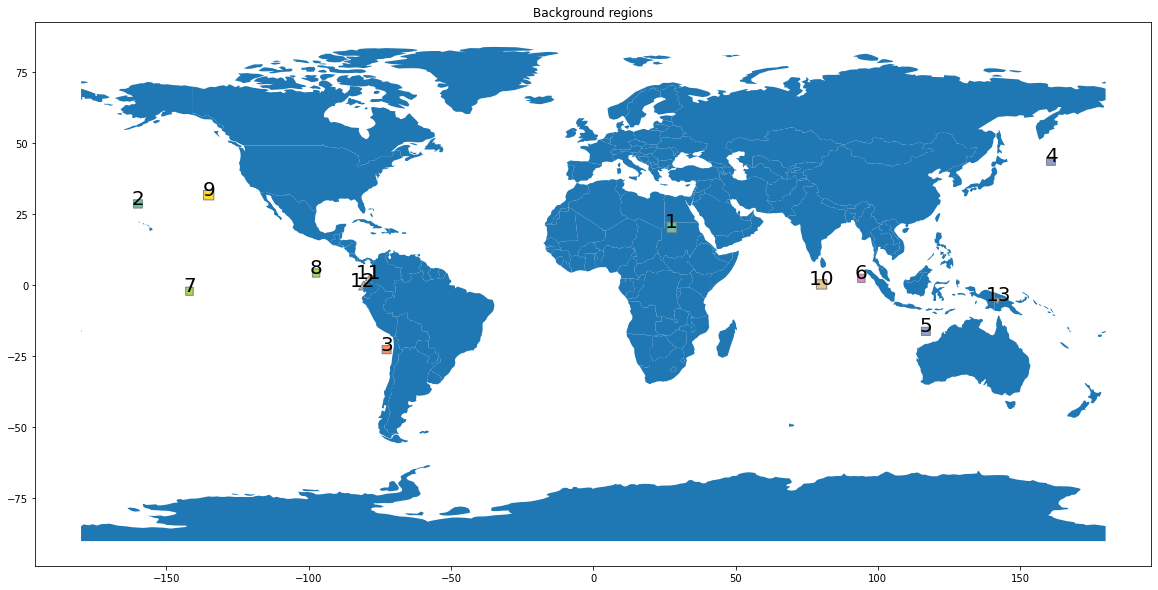

In [14]:
# geoplot.polyplot(world, figsize=(8, 4))
f, ax = plt.subplots(1, figsize=(20, 10))
ax.set_title('Background regions')
# Other nice categorical color maps (cmap) include 'Set2' and 'Set3'
world.plot(ax=ax)
bkg_vect.plot(ax=ax, cmap='Set2', edgecolor='gray')
bkg_vect.apply(lambda x: ax.annotate(s=x.ID, xy=x.geometry.centroid.coords[0], ha='center', fontsize=20),axis=1);
# ax.set_ylim([104, 110])
#ax.set_axis_off()
plt.axis('equal');
# plt.legend()
plt.savefig(data_path + 'background_regions_v' + str(version) + '.png')

(101,) (599,) (100, 598)
ID                                                          1
geometry    POLYGON ((25.90208498390001 22.08541624, 29.12...
Name: 0, dtype: object


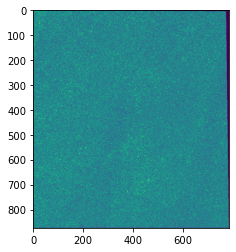

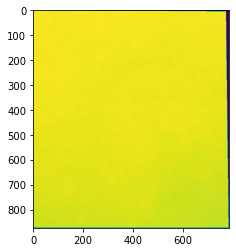

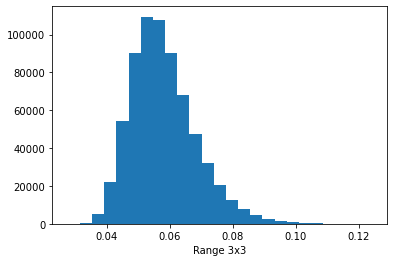

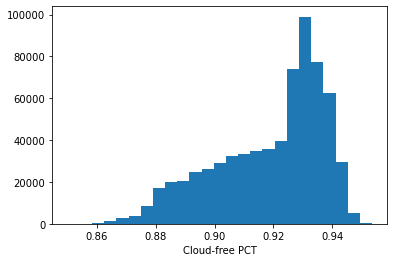

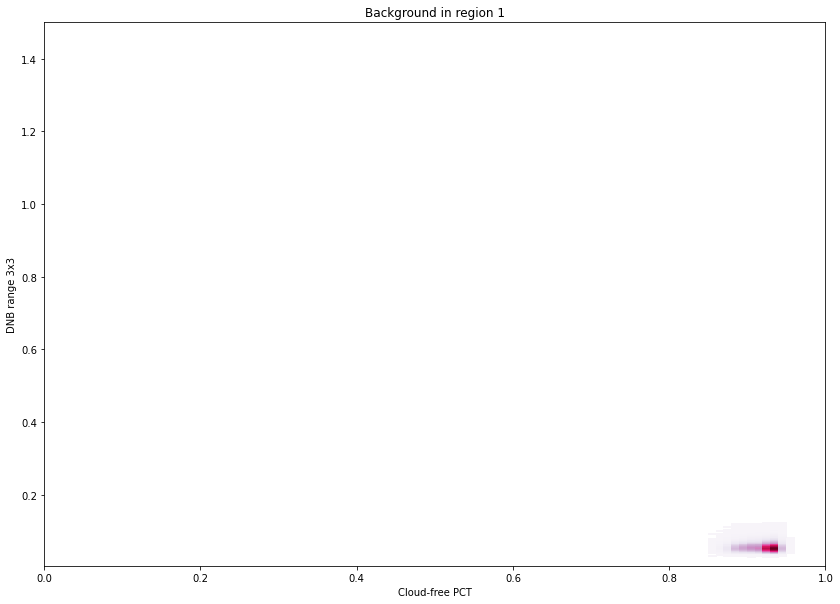

ID                                                          2
geometry    POLYGON ((-161.59374985275 29.93541630615, -15...
Name: 1, dtype: object


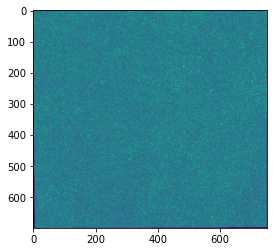

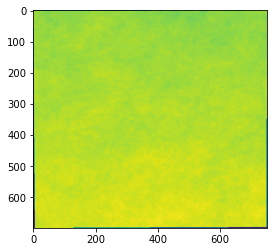

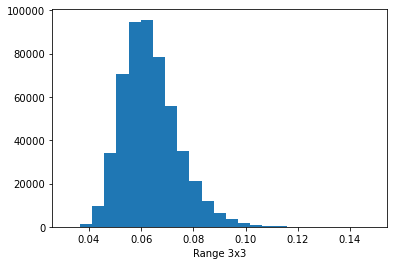

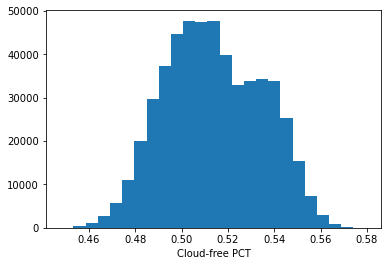

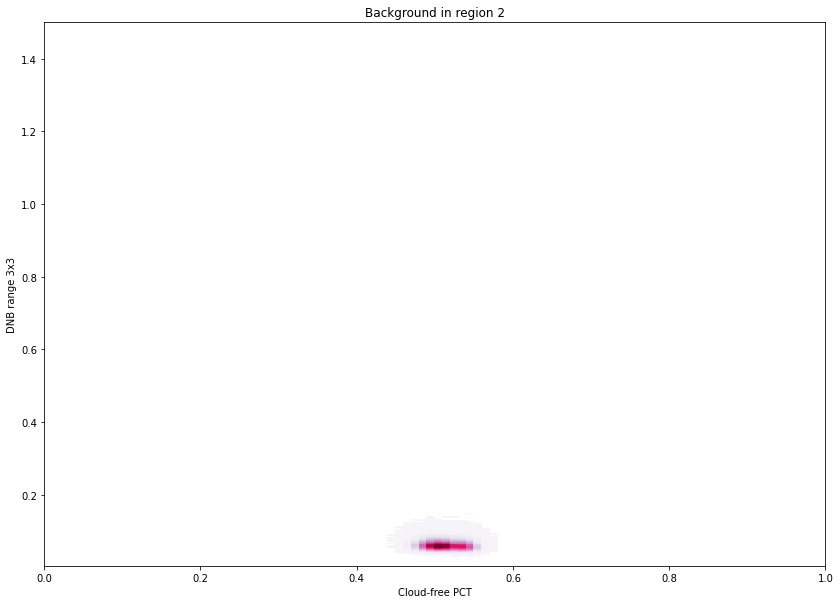

ID                                                          3
geometry    POLYGON ((-74.19374915355 -21.26041743675, -71...
Name: 2, dtype: object


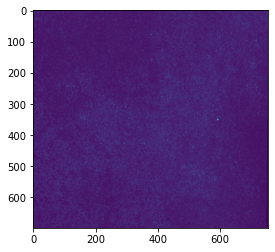

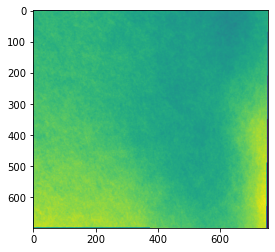

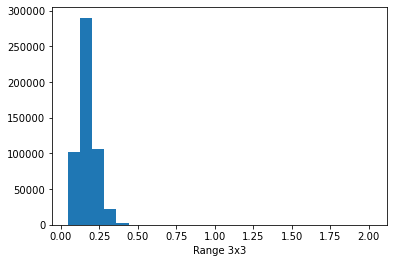

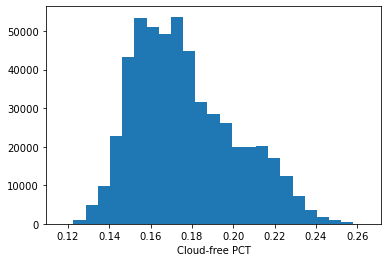

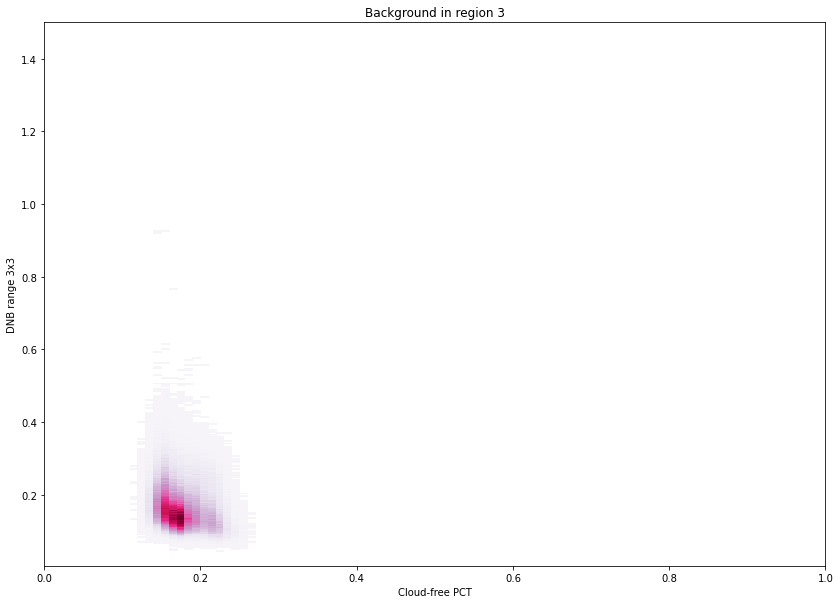

ID                                                          4
geometry    POLYGON ((159.25625271405 44.87708309235, 162....
Name: 3, dtype: object


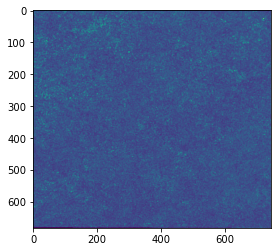

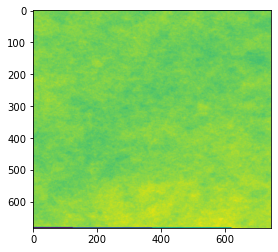

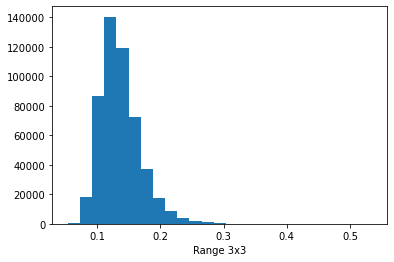

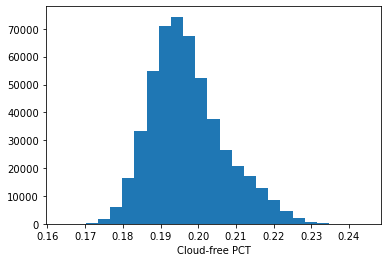

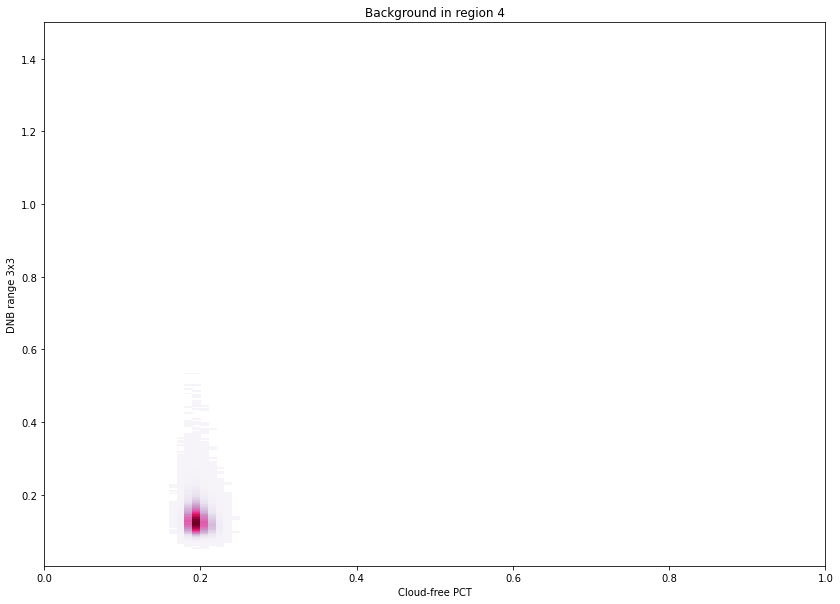

ID                                                          5
geometry    POLYGON ((115.27291902885 -14.86041738555001, ...
Name: 4, dtype: object


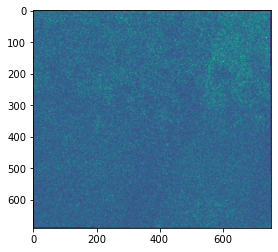

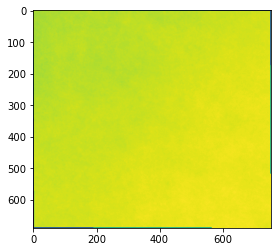

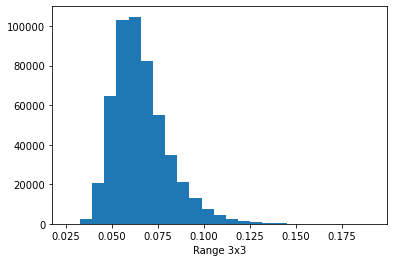

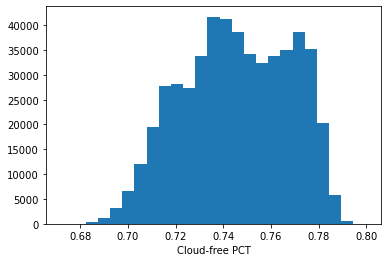

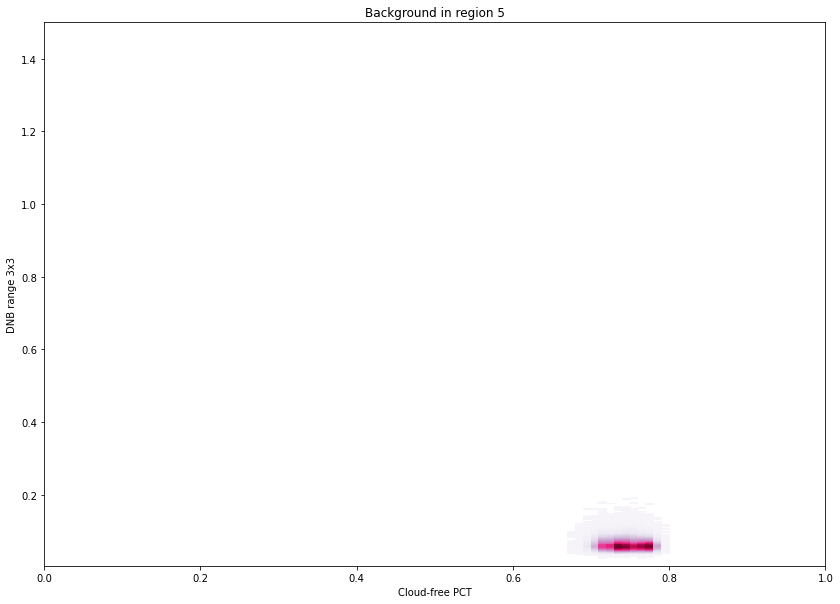

ID                                                          6
geometry    POLYGON ((92.86875218295 3.752082763350003, 95...
Name: 5, dtype: object


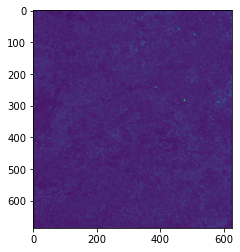

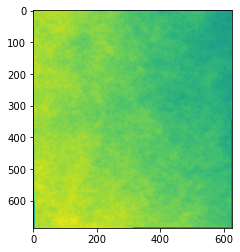

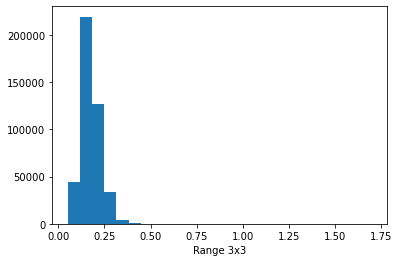

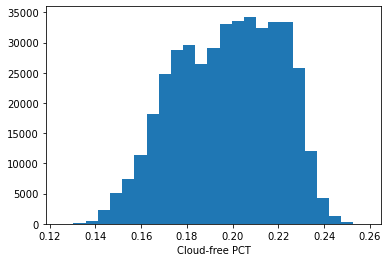

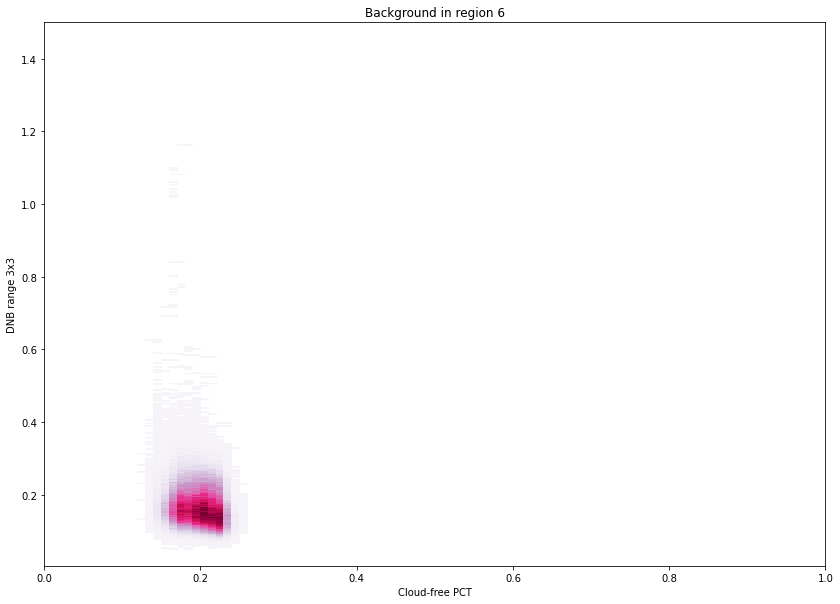

ID                                                          7
geometry    POLYGON ((-143.21458303905 -0.7770839395499962...
Name: 6, dtype: object


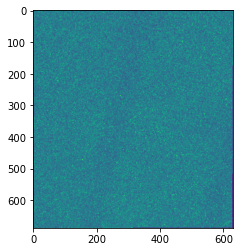

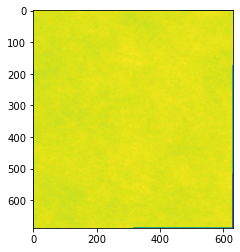

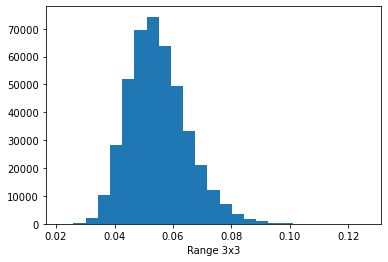

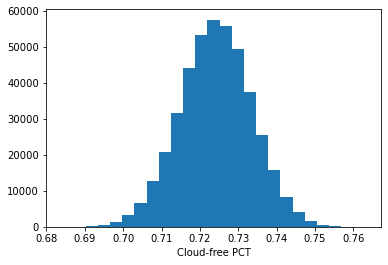

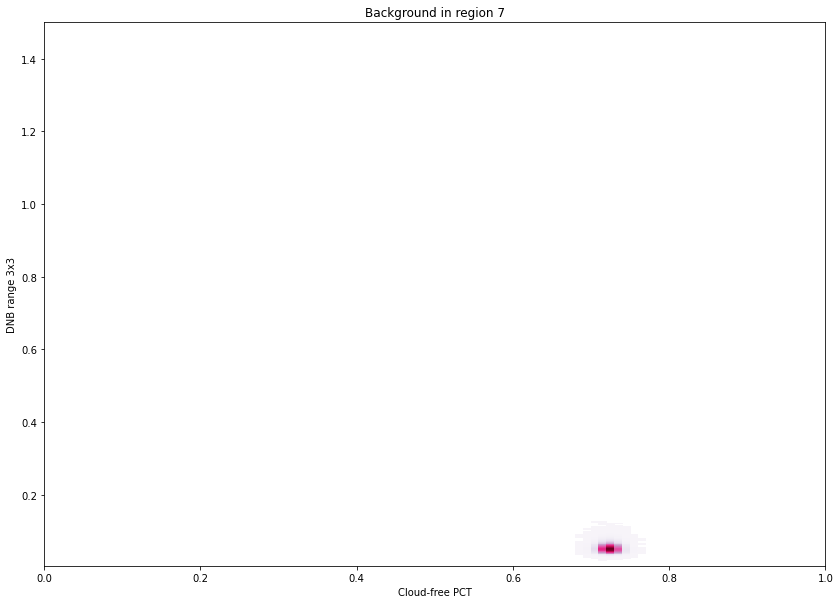

ID                                                          8
geometry    POLYGON ((-98.71458268305 5.618749444949998, -...
Name: 7, dtype: object


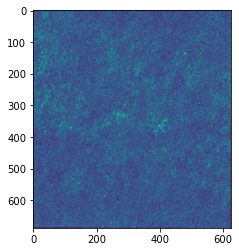

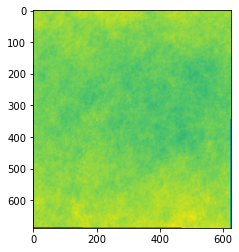

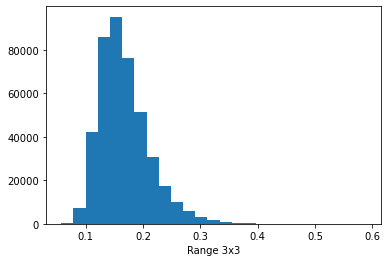

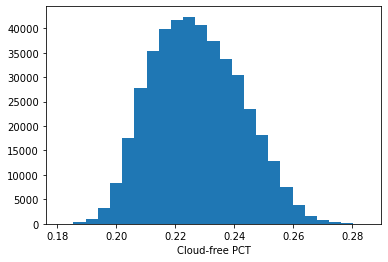

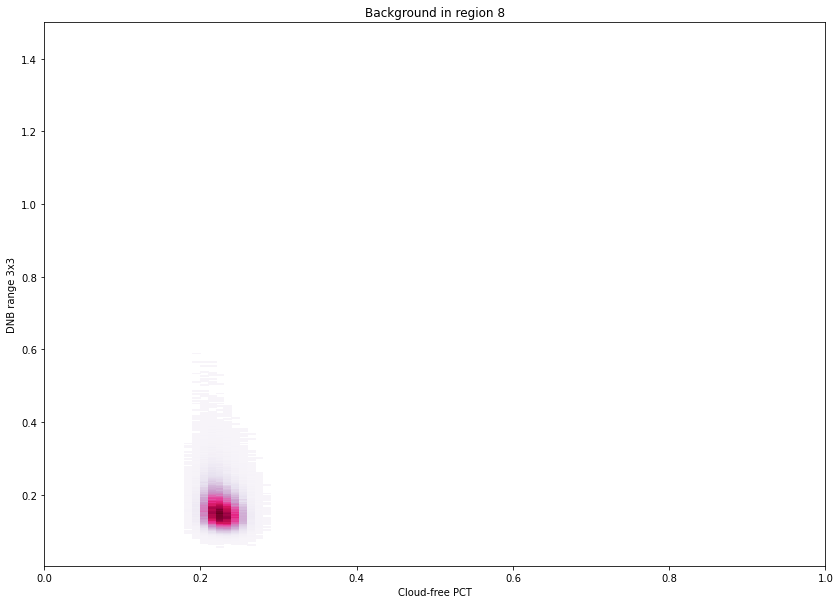

ID                                                          9
geometry    POLYGON ((-133.35624962685 33.19791633225, -13...
Name: 8, dtype: object


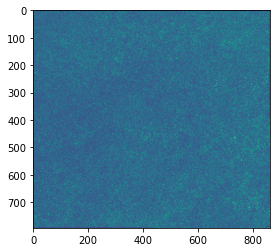

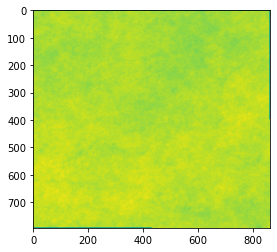

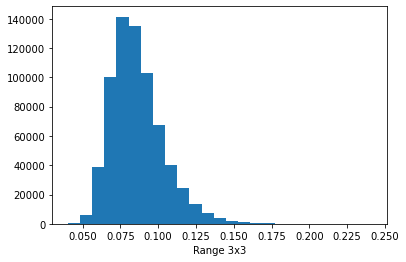

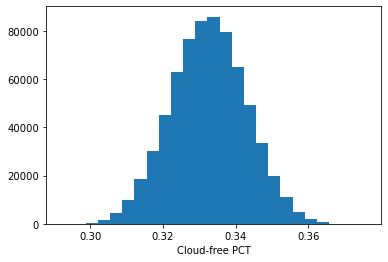

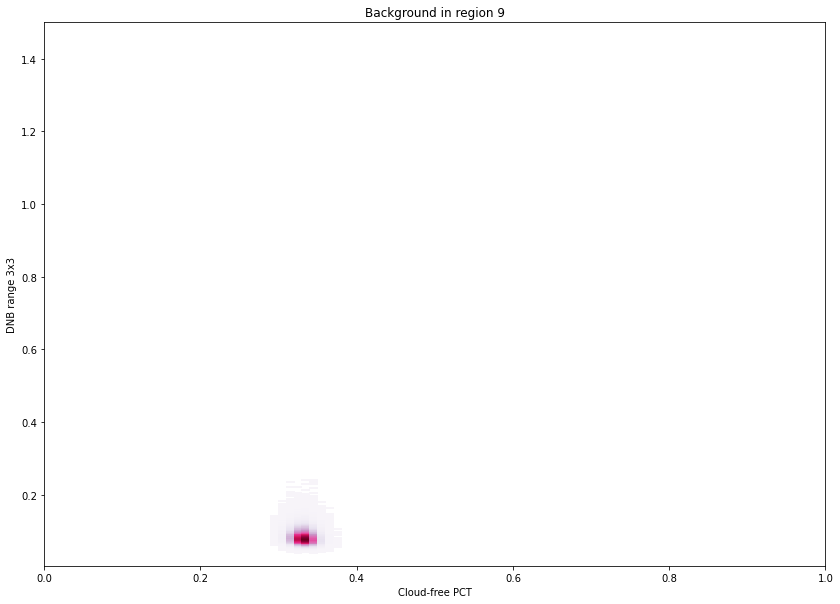

ID                                                         10
geometry    POLYGON ((78.38958540045002 1.847916081449995,...
Name: 9, dtype: object


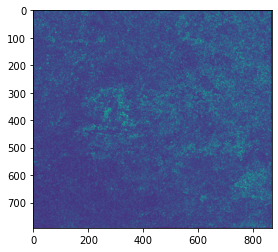

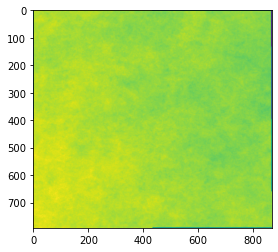

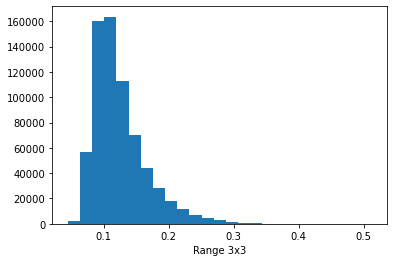

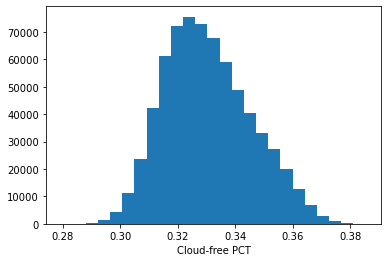

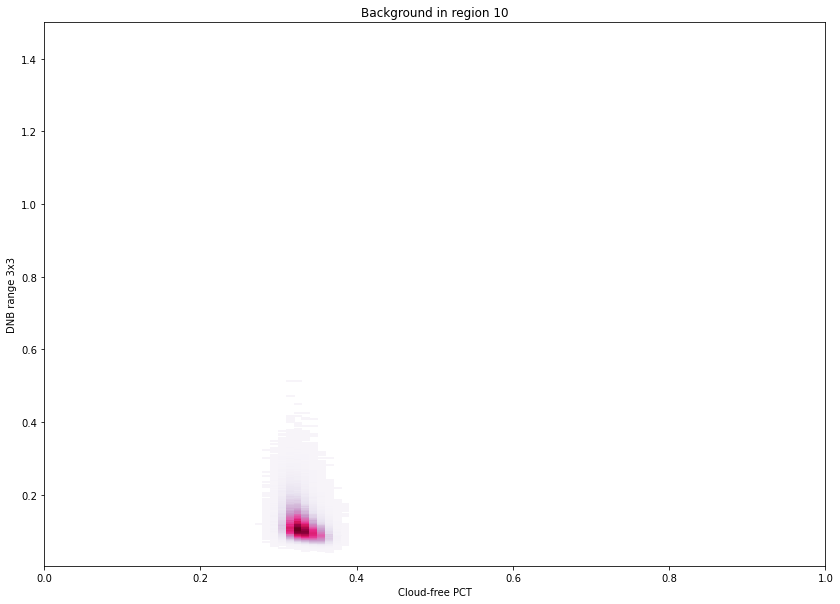

ID                                                         11
geometry    POLYGON ((-78.34791585010001 3.781249426900004...
Name: 10, dtype: object


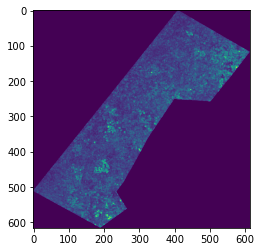

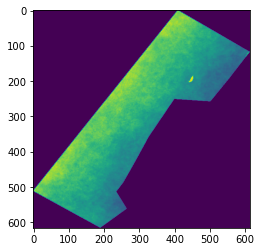

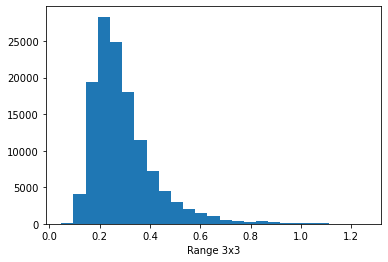

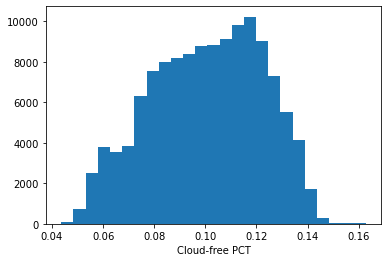

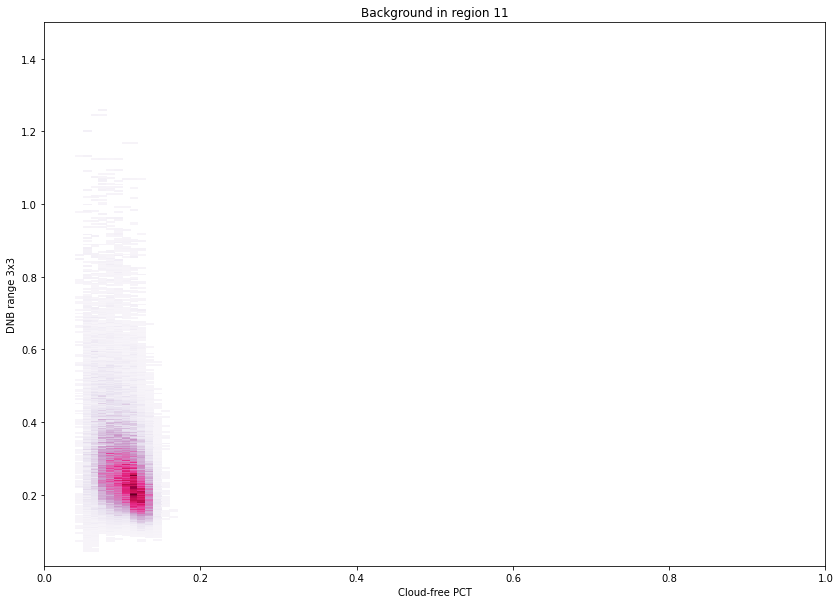

ID                                                         12
geometry    POLYGON ((-80.22291586510001 1.1979160729, -80...
Name: 11, dtype: object


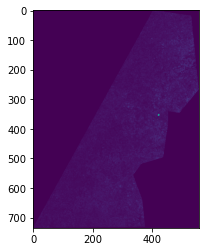

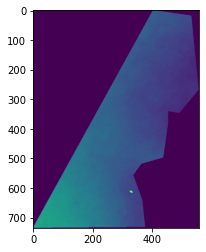

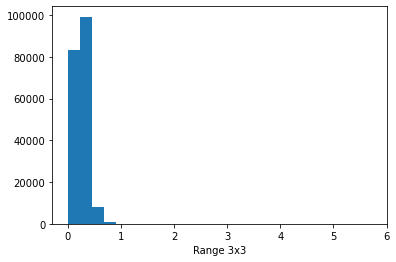

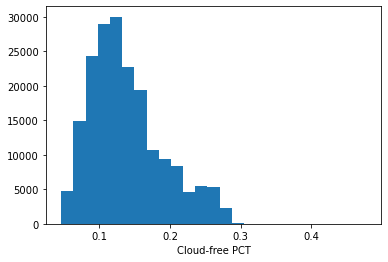

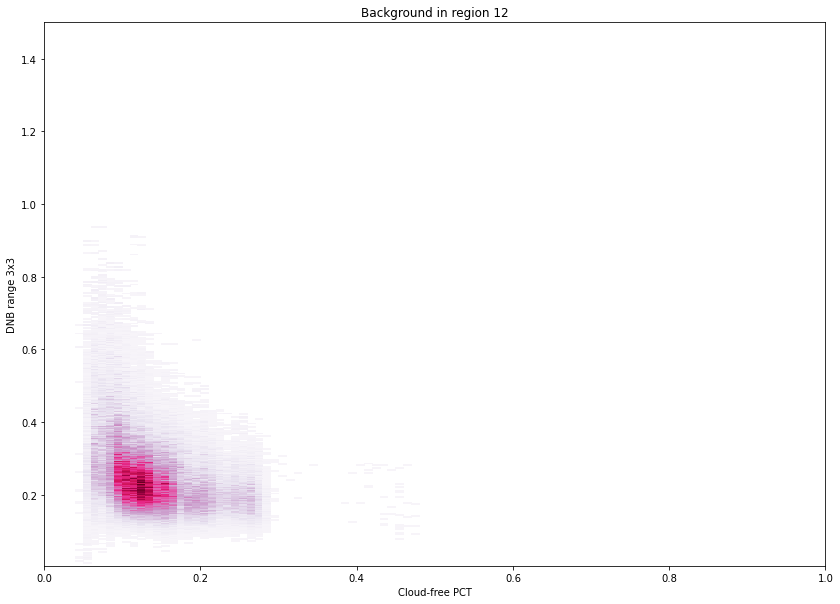

ID                                                         13
geometry    POLYGON ((141.0145859048 -4.656250640599993, 1...
Name: 12, dtype: object


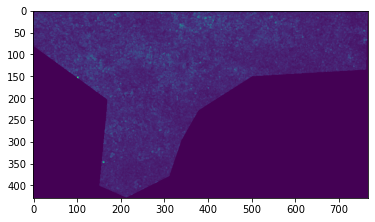

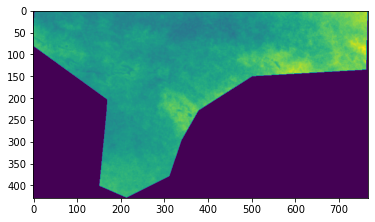

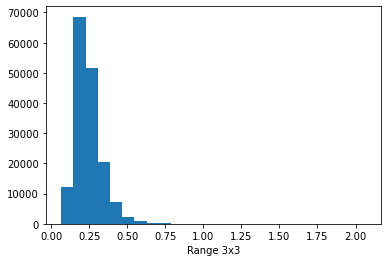

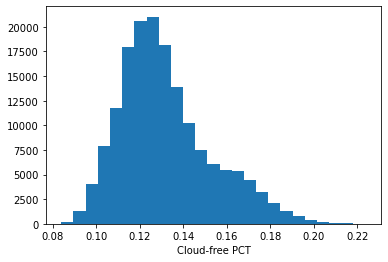

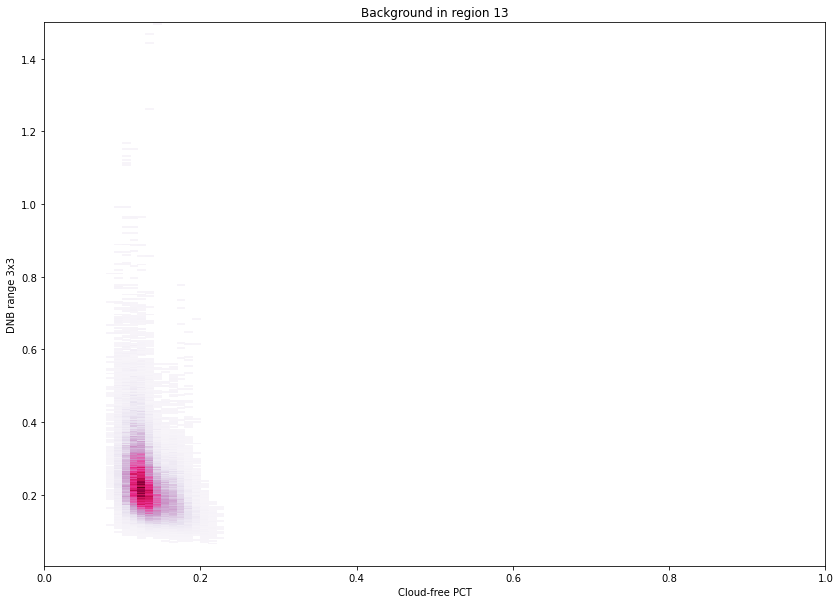

In [15]:
bin_size = 0.01; min_edge = 0; max_edge = 1
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
xbins = np.linspace(min_edge, max_edge, int(Nplus1))

bin_size = 0.0025; min_edge = 0.005; max_edge = 1.5
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
ybins = np.linspace(min_edge, max_edge, int(Nplus1))

H, _, _ = np.histogram2d([0], [0], bins=(xbins, ybins))

print(xbins.shape,ybins.shape,H.shape)

with rasterio.open(rangefile, 'r') as rng, \
    rasterio.open(pctfile, 'r') as pct:
    dst_profile = rng.profile.copy()

    T0 = rng.transform
    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)
    
    for index, regvect in bkg_vect.iterrows():
        print(regvect)
        rng_mask, rng_transform = mask(rng, [mapping(regvect.geometry)], crop=True)
        show(rng_mask)
        rng_vals = rng_mask[0,:,:].flatten()

        pct_mask, pct_transform = mask(pct, [mapping(regvect.geometry)], crop=True)
        show(pct_mask)
        pct_vals = pct_mask[0,:,:].flatten()
        
        rngnz = rng_vals[(rng_vals > 0) & (pct_vals > 0)]
        pctnz = pct_vals[(rng_vals > 0) & (pct_vals > 0)]
        
        plt.hist(rngnz,25)
        plt.savefig(data_path + 'range_region_' + str(index+1) + '.png')
        plt.xlabel('Range 3x3')
        plt.show()

        plt.hist(pctnz,25)
        plt.savefig(data_path + 'PCT_region_' + str(index+1) + '.png')
        plt.xlabel('Cloud-free PCT')
        plt.show()

        Htmp, _, _ = np.histogram2d(pctnz, rngnz, bins=(xbins, ybins))
        H += Htmp/np.amax(Htmp)
#         H = np.maximum(H,Htmp/np.sum(Htmp))
        
        # H needs to be rotated and flipped
        Hplt = np.rot90(Htmp)
        Hplt = np.flipud(Hplt)

        # Mask zeros
        Hmasked = np.ma.masked_where(Hplt==0,Hplt) # Mask pixels with a value of zero
#         Hmasked[0:1,:] = np.NaN

        f, ax1 = plt.subplots(1,figsize=(14, 10),facecolor='w')
        ax1.pcolormesh(xbins, ybins, Hmasked, cmap='PuRd')
        ax1.set_title('Background in region ' + str(index+1))        
#         ax1.pcolormesh(xbins, ybins, Hmasked, cmap='gist_ncar')
        plt.xlabel('Cloud-free PCT')
        plt.ylabel('DNB range 3x3')
        plt.savefig(data_path + 'PCT_vs_range_region_' + str(index+1) + '_v' + str(version) + '.png')
        plt.show()

0.9999907102744945
0.20000718159387104
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]
['0', '20', '40', '60', '80', '100']


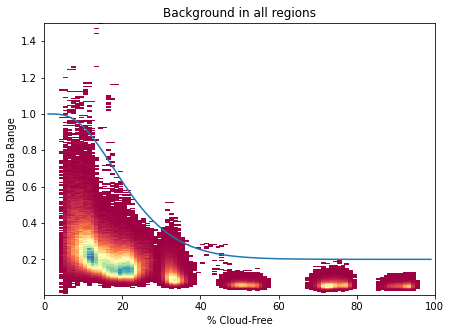

In [16]:
import scipy.special as sc
import scipy.stats as stats

# H needs to be rotated and flipped
Hplt = np.rot90(H)
Hplt = np.flipud(Hplt)

# Mask zeros
Hmasked = np.ma.masked_where(Hplt==0,Hplt) # Mask pixels with a value of zero
Hmasked[0:1,:] = np.NaN

x = np.arange(0.01, 1.0, 0.01)
y = 1.25 - sc.gammainc(4.5,20*x)
y = y / 1.25
print(np.amax(y))
print(np.amin(y))
# y = stats.gamma.pdf(x, a=2, scale=0.5)

print(x)

f, ax1 = plt.subplots(1,figsize=(7, 5),facecolor='w')
# ax1.pcolormesh(xbins, ybins, Hmasked, cmap='PuRd')
# ax1.pcolormesh(xbins, ybins, Hmasked, cmap='gist_ncar')
# ax1.pcolormesh(xbins, ybins, Hmasked, cmap='jet')
# ax1.pcolormesh(xbins, ybins, Hmasked, cmap='cool')
ax1.pcolormesh(xbins, ybins, Hmasked, cmap='Spectral')

ax1.plot(x,y)
xtks = [0,0.2,0.4,0.6,0.8,1.0]
ax1.set_xticks(xtks)
xlabels = list(map(str,(100*np.array(xtks)).astype('int')))
print(xlabels)
ax1.set_xticklabels(xlabels)

# plt.xlabel('Cloud-free PCT', fontsize = 20)
# plt.ylabel('DNB range 3x3', fontsize = 20)
# ax1.set_title('Background in all regions', size = 20)        
plt.xlabel('% Cloud-Free')
plt.ylabel('DNB Data Range')
ax1.set_title('Background in all regions')
plt.savefig(data_path + 'PCT_vs_range_all_regions_v' + str(version) + '.png',dpi=300)
plt.show()

In [17]:
# https://github.com/mapbox/rasterio/blob/master/docs/topics/windowed-rw.rst

t0 = time.time()

MEDIAN_THR = 0.4
RANGE_THR_LOW = 0.2
RANGE_THR_HIGH = 1.0

bin_size = 0.0025; min_edge = 0; max_edge = 1
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
xbins = np.linspace(min_edge, max_edge, int(Nplus1))

bin_size = 0.005; min_edge = 0; max_edge = 1
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
ybins = np.linspace(min_edge, max_edge, int(Nplus1))

Hall, _, _ = np.histogram2d([0], [0], bins=(xbins, ybins))

print(xbins.shape,ybins.shape,H.shape)

with rasterio.open(medfile, 'r') as med, \
    rasterio.open(rangefile, 'r') as rng, \
    rasterio.open(pctfile, 'r') as pct:
    dst_profile = rng.profile.copy()
#     dst_profile = {**dst_profile,'driver': 'GTiff'}

    width = rng.profile['width']
    height = rng.profile['height']

    print(dst_profile)

    T0 = rng.transform

    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)
    # Function to convert pixel row/column index (from 0) to easting/northing at centre
    rc2en = lambda r, c:  T1 * (c, r)
    
    bkg_mask = rasterio.features.geometry_mask(
        bkg_vect.geometry,
        out_shape=(height,width),
        transform=T1,
        invert=True,
        all_touched=True)    
    
    count = 0
    for i in range(0,height):

        # All eastings and northings (there is probably a faster way to do this)
        cols, rows = np.meshgrid(range(width), i)            
        lons, lats = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)
#             print(lons.shape,lats.shape)

        if i % 100 == 0:
            t1 = time.time()
            print('line',i,'elapsed',t1-t0)        
                
        if lats[0,0] <= south_bkg_limit or lats[0,0] >= north_bkg_limit:
            continue
            
        med_line = med.read(1,window=Window(0, i, width, 1))
        rng_line = rng.read(1,window=Window(0, i, width, 1))
        pct_line = pct.read(1,window=Window(0, i, width, 1))

#         print(i)

        bkg_line = bkg_mask[i,:]

        medfl = med_line.flatten()
        rngfl = rng_line.flatten()
        pctfl = pct_line.flatten()
        rngnz = rngfl[(medfl < 0.5)]
        pctnz = pctfl[(medfl < 0.5)]
#         rngnz = rngfl[bkg_line == 1]
#         pctnz = pctfl[bkg_line == 1]
        
#         if np.any(bkg_line):
#             print('bkg line')

        Htmp, _, _ = np.histogram2d(pctnz, rngnz, bins=(xbins, ybins))
        Hall += Htmp
        
        count += 1
        
#         if count > 10000:
#             break

    print(count)

(401,) (201,) (100, 598)


NameError: name 'medfile' is not defined

In [ ]:
# H needs to be rotated and flipped
Hplt = np.rot90(Hall)
Hplt = np.flipud(Hplt)

# Mask zeros
Hmasked = np.ma.masked_where(Hplt==0,Hplt) # Mask pixels with a value of zero

# cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

f, ax1 = plt.subplots(1,figsize=(14, 10),facecolor='w')
# ax1.pcolormesh(xbins, ybins, Hmasked, cmap=cmap)
im = ax1.pcolormesh(xbins, ybins, Hmasked, cmap='PuRd')
ax1.set_ylim([0,0.5])
# im = ax1.pcolormesh(xbins, ybins, Hmasked, cmap='gist_ncar')
plt.xlabel('Cloud-free PCT')
plt.ylabel('DNB range 3x3')
f.colorbar(im, ax=ax1)
plt.savefig(data_path + 'PCT_vs_range_DNB_med_lt_0.5.png')
plt.show()